# Sistemas de Controle 2 – Tarefa sobre o projeto no 1 – Controle Digital

In [1]:
from numpy import pi, exp, sqrt, angle, real, tan, imag, abs
import numpy as np
from scipy.optimize import fsolve
from control import tf
from control.matlab import c2d, step, rlocus
from matplotlib.pyplot import plot, grid, show, xlim

## 1. Para o circuito da Figura 1 e determinar a função de transferência do sistema contínuo

30.1587%
zeta = 0.3565 | wn = 175.1307


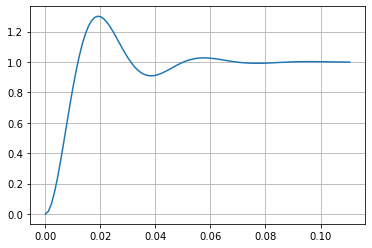

TransferFunction(array([30670.7787964]), array([1.00000000e+00, 1.24864140e+02, 3.06707788e+04]))

In [2]:
# Mp = D1/D2
D1 = 2.30 - 2.16
D2 = 2.16 - 1.66
Mp = D1 / D2

tp = 19.2e-3
delta2 = 504e-3
delta1 = 152e-3

Mp = delta1/delta2
print(f'{Mp:.4%}')

zeta = fsolve(lambda zeta: exp(-pi*zeta/sqrt(1-zeta**2)) - Mp, 0)[0]

zeta = sqrt(pow(np.log(Mp),2)/(pow(pi, 2) + pow(np.log(Mp),2)))

wn = pi/(tp*sqrt(1-zeta**2))

print(f'zeta = {zeta:.4f} | wn = {wn:.4f}')


tp = 12e-3 + 7.2e-3
# tp = pi / (wn * sqrt(1 - zeta**2))
# wn = pi / (tp * sqrt(1 - zeta**2))
wn = pi / (tp * sqrt(1-zeta**2))

Gs = tf([wn**2],[1, 2*zeta*wn, wn**2])

y, t = step(Gs)

plot(t, y)
grid()
show()

Gs

## 2. Elaborar o projeto dos seguintes controladores digitais

In [3]:
Req = {
    'ts5%': len('RaquelDutraKotzias')*1e-3,
    'ess': 0,
    'Mp': (2*len('Raquel'))/100
}
print(f'Requisitos de projeto: {Req}')

# Calcula o zeta a partir do Mp desejado
zeta = fsolve(lambda zeta: exp(-pi*zeta/sqrt(1-zeta**2)) - Req['Mp'], zeta)[0]

# Calcula o wn a partir do zeta e ts5% desejado
wn = fsolve(lambda wn: 4/(zeta*wn) - Req['ts5%'], wn)[0]

wd = wn*sqrt(1-zeta**2)
ws = 9.07 * wd
#ws = 20 * wd

T = 2*pi/ws
print(f'Zeta: {zeta:.2f}')
print(f'wn: {wn:.2f} rad/s')
print(f'T: {T*1000:.2f} ms')

Requisitos de projeto: {'ts5%': 0.018000000000000002, 'ess': 0, 'Mp': 0.12}
Zeta: 0.56
wn: 397.24 rad/s
T: 2.10 ms


### 2.1 – Projeto de controlador digital no plano z pelo método do lugar das raízes.

O polo desejado está em 0.48+0.40j
[ 1.         -1.6509216   0.76897129]
Com beta = -0.19 temos <FTMD(z1) = -180.00
Com K = 3.63 temos |FTMD(z1)| = 1.00


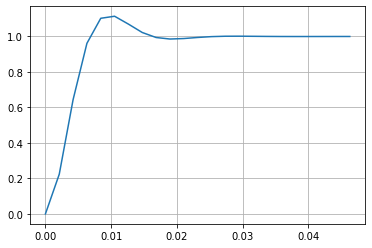

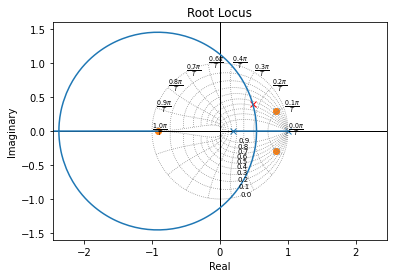


3.628 z^2 - 5.99 z + 2.79
-------------------------
 z^2 - 1.188 z + 0.1878

dt = 0.002103899870540361



TransferFunction(array([0.06161791, 0.05643178]), array([ 1.        , -1.6509216 ,  0.76897129]), 0.002103899870540361)

In [11]:
# Transforma a planta continua em digital
Gz = c2d(Gs, T)

z_abs = exp(-2*pi*zeta/sqrt(1-zeta**2)*wd/ws)
z_ang = T*wd

# Polo desejado
z1 = z_abs*exp(1j * z_ang)
print(f'O polo desejado está em {z1:.2f}')

# O controlador pode ser separado em K * zeros/1 * 1/(Z-1) * 1/(Z + beta) = K * Cz * Ci * Cp = C

# O zeros serão os polos da planta (com o objetivo de anular os polos da planta)
Cz = tf(Gz.den[0][0], [1], T)

# Ci tem o objetivo de obter um polo em z=1 para obter erro nulo ao degrau
Ci = tf([1],[1, -1], T)

# Cp será definido a partir da condição de angulo (<Cz + <Ci + <Cp + <Gz = +- 180 com z = z1)
# logo <Cp = 180 - <Ci - <Cz - <Gz com z = z1
ang_Cp = pi - angle(Ci(z1)) - angle(Cz(z1)) - angle(Gz(z1))

# Cp = 1/(z + beta) -> <Cp = -<(z + beta) = -arctan(Im{z} / (Re{z} + beta))
# beta = Im{z1} / tan(-<Cp(z1)) - Re{z1}
beta = imag(z1) / tan(-ang_Cp) - real(z1)
Cp = tf([1],[1, beta], T)

# conferindo a condição de ângulo
FTMD_semGanho = Cz * Ci * Cp * Gz
print(f'Com beta = {beta:.2f} temos <FTMD(z1) = {angle(FTMD_semGanho(z1))*180/pi:.2f}')

# O K será definido a partir da condição de modulo (K*|Cz*Ci*Cp*Gz| = 1 quando z = z1)
# K = 1/|FTMD_semGanho| quando z = z1
K = 1/abs(FTMD_semGanho(z1))
C = K * Cz * Ci * Cp

# conferindo a condição de modulo
FTMD = K * FTMD_semGanho
print(f'Com K = {K:.2f} temos |FTMD(z1)| = {abs(FTMD(z1)):.2f}')

FTMF = FTMD/(1 + FTMD) # Nesse caso temos Malha aberta = Malha direta pois a função de realimentação é unitária

y, t = step(FTMF, T*range(0,int(0.05/T)))

plot(t, y)
grid()
show()

_, _ = rlocus(C*Gz/K, [0,1,2,3])
xlim((-0.5,0.5))
plot(real(z1), imag(z1), 'rx')
show()

print(C)
Gz

### 2.2 – Projeto de controlador digital pela conversão de um controlador analógico

O polo desejado está em -222.22+329.27j
Para um pc = 756.19 obtemos <FTMD(s1) = 180.00°
Para um K = 6.83 obtemos |FTMF(s1)| = 1.00


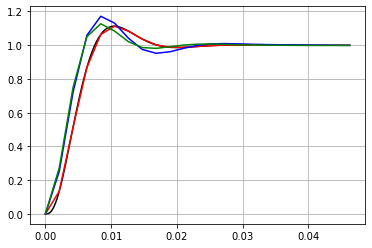

In [5]:
Gzoh = tf([2/T], [1, 2/T])

Gd = Gzoh * Gs

# Definir o polo desejado
# os valores de zeta e wn são os mesmos calculados no inicio da parte 2
s1 = -zeta*wn + 1j*wn*sqrt(1-zeta**2)
print(f'O polo desejado está em {s1:.2f}')

# Para o controlador analogico podemos separar Cs = K * Cz * Ci * Cp
# Onde Cz = (s-p1)*(s-p2)*(s-pn)/1 sendo p1,p2,...pn os polos da planta
Cz = tf(Gs.den[0][0], [1])
# Ci é um integrador 1/s pois queremos ess = 0
Ci = tf([1],[1, 0])
# Cp = (s - pc)

# Condição de fase: <Cz + <Ci + <Cp + <Gd = +- 180 quando s = s1
ang_Cp_s1 = pi - angle(Cz(s1)) - angle(Ci(s1)) - angle(Gd(s1))

# Cp = 1/(s + pc) -> <Cp(s1) = -<(s1 + pc) = -arctan(Im{s1}/[Re{s1} + pc])
pc = imag(s1)/tan(-ang_Cp_s1) - real(s1)
Cp = tf([1],[1, pc])

# Conferindo a condição de angulo
FTMD_semGanho = Cz * Ci * Cp * Gd
print(f'Para um pc = {pc:.2f} obtemos <FTMD(s1) = {angle(FTMD_semGanho(s1))*180/pi:.2f}°')

# Condição de modulo: K * |Cz*Ci*Cp*Gd| = 1 = K * |FTMD_semGanho| para s = s1
K = 1/abs(FTMD_semGanho(s1))

# Conferindo a condição de modulo
Cs = K * Cp * Ci * Cz
FTMD = Cs * Gd
print(f'Para um K = {K:.2f} obtemos |FTMF(s1)| = {abs(FTMD(s1)):.2f}')

FTMF = FTMD/(1 + FTMD) # Nesse caso temos Malha aberta = Malha direta pois a função de realimentação é unitária

y, t = step(FTMF)

plot(t, y, 'black')

C_zoh = c2d(Cs, T)
C_foh = c2d(Cs, T, method='foh')
C_tustin = c2d(Cs, T, method='tustin')

FTMD_zoh = C_zoh * Gz
FTMD_foh = C_foh * Gz
FTMD_tustin = C_tustin * Gz

FTMF_zoh = FTMD/(1 + FTMD) # Nesse caso temos Malha aberta = Malha direta pois a função de realimentação é unitária
FTMF_foh = FTMD_foh/(1 + FTMD_foh)
FTMF_tustin =FTMD_tustin/(1 + FTMD_tustin)

y, t = step(FTMF_zoh, T*range(0, int(0.05/T)))
plot(t, y, 'red')

y, t = step(FTMF_foh, T*range(0, int(0.05/T)))
plot(t, y, 'blue')

y, t = step(FTMF_tustin, T*range(0, int(0.05/T)))
plot(t, y, 'green')

grid()
show()